In [571]:
import warnings
warnings.filterwarnings('ignore')

In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

## VERİ TANITIMI

In [573]:
# 1. Data Loading & Initial Analysis
def summarize_data(df):
    print("Veri setinin boyutu:", df.shape)
    print("\nVeri türleri:")
    print(df.dtypes)
    print("\nSınıf dağılımı:")
    print(df['quality'].value_counts())
    print("\nEksik veriler:")
    missing_data = df.isnull().sum()
    print(missing_data[missing_data > 0])

In [574]:
# Load data
df = pd.read_csv("D:\\gitClones\\Machine-learning-assignment\\data\\WineQT_missing.csv")

In [575]:
summarize_data(df)

Veri setinin boyutu: (1143, 13)

Veri türleri:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object

Sınıf dağılımı:
quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

Eksik veriler:
fixed acidity           6
volatile acidity        4
citric acid             2
residual sugar          8
chlorides               6
free sulfur dioxide     2
total sulfur dioxide    5
density                 2
pH                      2
sulphates               4
alcohol                 3
dtype: int64


## Sürekli ve Kategorik Değişkenlerin Belirlenmesi<br>
     separate_variables() fonksiyonunda veri tipi ve tekil sınıf sayısına göre değişkenlerin türü belirlenir

In [576]:
def separate_variables(df):
    # Sürekli değişkenler (float/int ve unique değer sayısı yüksek)
    continuous = [col for col in df.columns if 
                 (df[col].dtype in ['float64', 'int64']) and 
                 (df[col].nunique() > 10) and 
                 (col not in ['quality', 'Id'])]
    
    # Kategorik değişkenler (object tipi veya az unique değer)
    categorical = [col for col in df.columns if 
                  (df[col].dtype in ['object']) or 
                  (df[col].nunique() <= 10) or 
                  (col in ['quality'])]
    
    print("Sürekli Değişkenler:")
    print(continuous)
    print("\nKategorik Değişkenler:")
    print(categorical)
    
    return continuous, categorical

# Fonksiyonu çağır
continuous_vars, categorical_vars = separate_variables(df)

Sürekli Değişkenler:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Kategorik Değişkenler:
['quality']


### Histogram ve KDE (Kernel Density Estimation)

Histogramlar, veri setinin dağılımını görselleştirmek için kullanılan grafiklerdir. Bir histogram, veri aralığını belirli sayıda bölmelere (bin) ayırır ve her bir bölmede kaç veri noktası olduğunu gösterir. Bu, veri setinin yoğunluklarını ve dağılımını anlamamıza yardımcı olur.

KDE (Kernel Density Estimation), histogramın daha pürüzsüz bir versiyonunu sağlar. KDE, veri noktalarının yoğunluğunu tahmin etmek için bir çekirdek fonksiyonu kullanır ve bu sayede veri dağılımını daha sürekli ve pürüzsüz bir şekilde görselleştirir. KDE, histogramdaki keskin geçişleri yumuşatarak, veri setinin altında yatan gerçek dağılımı daha iyi anlamamıza yardımcı olabilir.


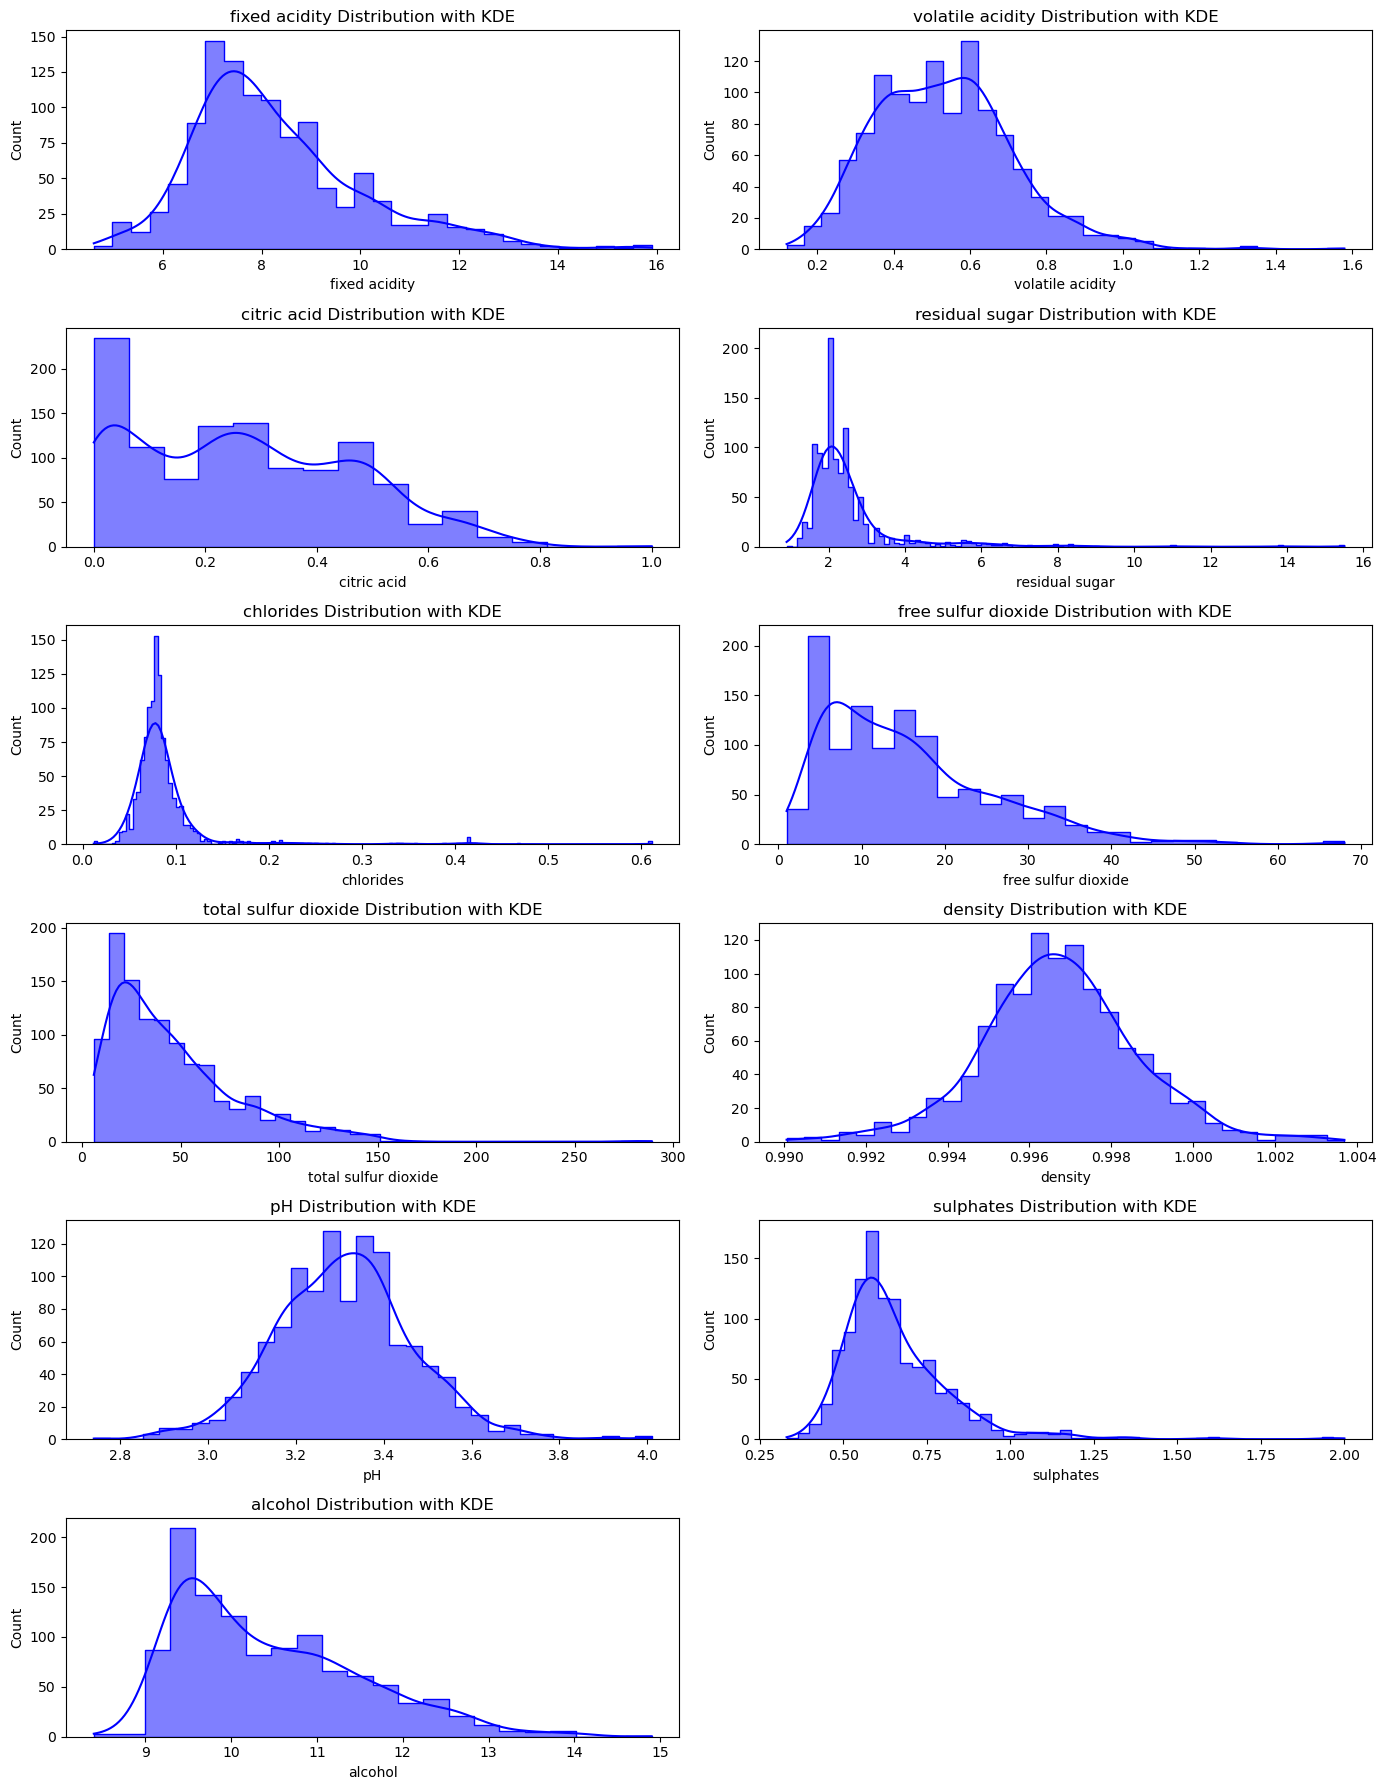

In [577]:
def plot_kde_histograms(df, continuous_vars):
    num_vars = len(continuous_vars)
    num_rows = (num_vars + 1) // 2  # Her satırda iki grafik olacak şekilde satır sayısını hesapla
    
    plt.figure(figsize=(14, num_rows * 3))
    
    for i, var in enumerate(continuous_vars):
        plt.subplot(num_rows, 2, i + 1)
        sns.histplot(df[var], kde=True, element= "step", color='blue')
        plt.title(f'{var} Distribution with KDE')
    
    plt.tight_layout()
    plt.show()

plot_kde_histograms(df, continuous_vars)

### Boxplot

Boxplot (kutu grafiği), veri setinin dağılımını ve özet istatistiklerini görselleştirmek için kullanılan bir grafik türüdür. Boxplot, aşağıdaki bileşenleri içerir:

- **Median (Ortanca)**: Kutu içindeki yatay çizgi, veri setinin ortanca değerini gösterir. Bu, veri setinin ortasındaki değeri temsil eder.
- **Quartiles (Çeyrekler)**: Kutu, veri setinin birinci çeyreği (Q1) ve üçüncü çeyreği (Q3) arasındaki aralığı gösterir. Bu, veri setinin ortadaki %50'sini kapsar.
- **Interquartile Range (IQR)**: Q3 ile Q1 arasındaki farktır. Kutu grafiğinde kutunun uzunluğu olarak temsil edilir.
- **Whiskers (Bıyıklar)**: Bıyıklar, genellikle Q1 - 1.5\*IQR ve Q3 + 1.5\*IQR aralığını gösterir. Bu aralık dışındaki veri noktaları aykırı değerler olarak kabul edilir.
- **Outliers (Aykırı Değerler)**: Bıyıkların dışında kalan veri noktalarıdır. Genellikle küçük daireler veya yıldızlar ile gösterilir.

### Boxplot'ın Kullanım Amaçları

- **Dağılımı Görselleştirme**: Veri setinin merkezi eğilimlerini, yayılımını ve simetrisini görselleştirir.
- **Aykırı Değerleri Belirleme**: Aykırı değerleri hızlıca tespit etmeye yardımcı olur.
- **Karşılaştırma**: Farklı veri gruplarının dağılımlarını karşılaştırmak için kullanılır.
- **Özet İstatistikler**: Veri setinin temel özet istatistiklerini (medyan, çeyrekler, IQR) görselleştirir.

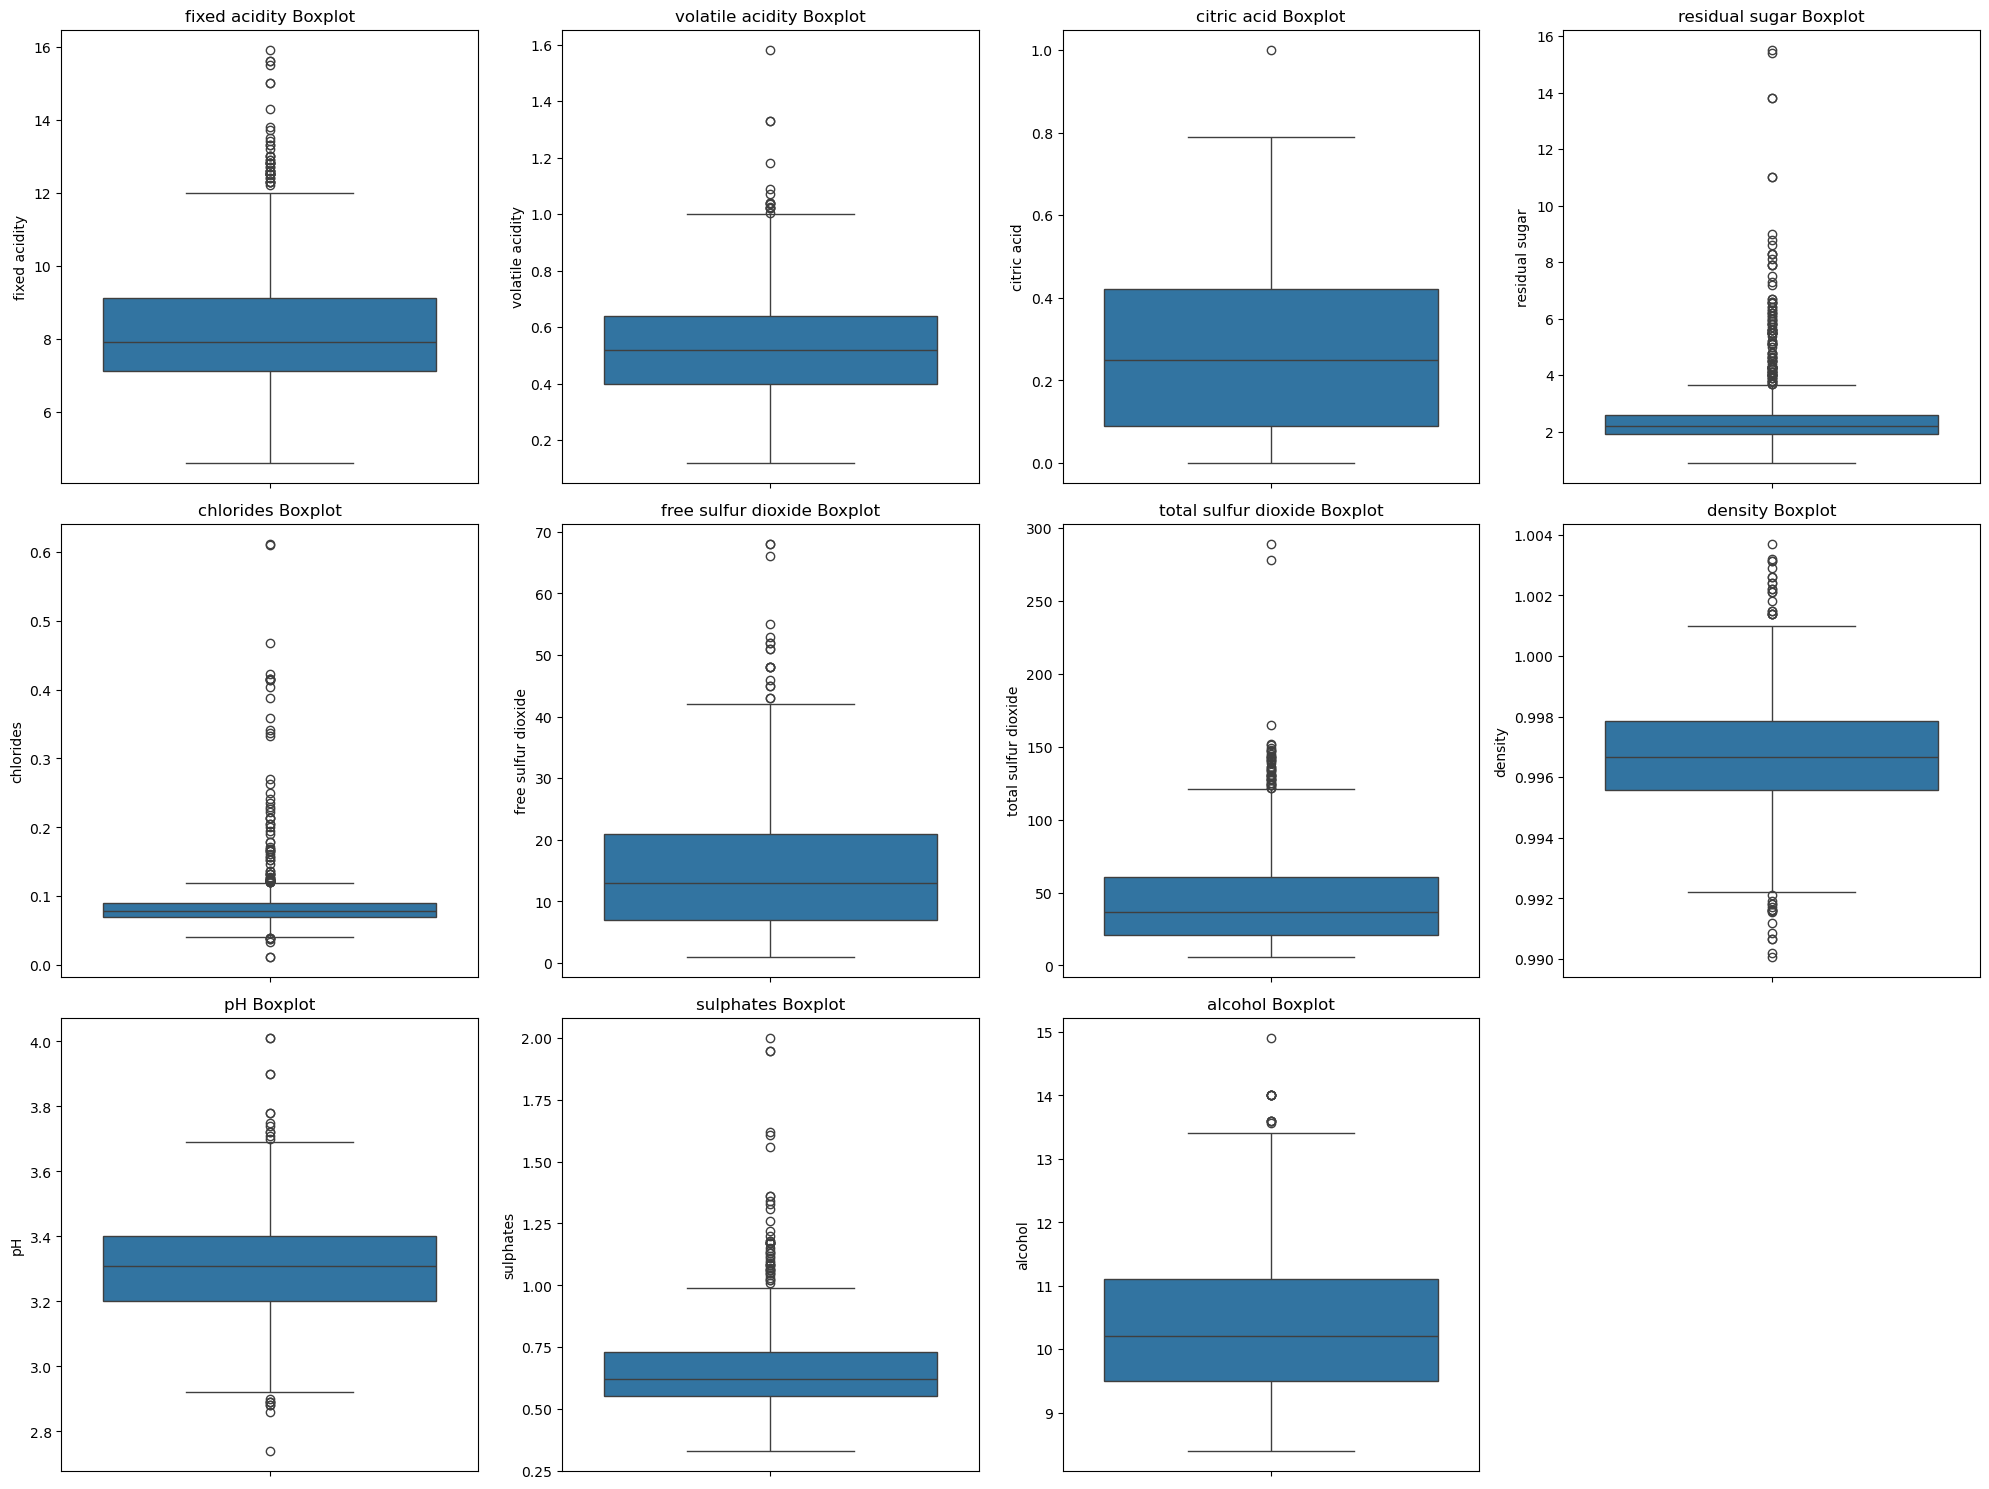

In [578]:
def plot_boxplots(df, continuous_vars):
    num_vars = len(continuous_vars)
    num_cols = 4  # Her satırda 4 grafik olacak
    num_rows = (num_vars + num_cols - 1) // num_cols  # Satır sayısını hesapla
    
    plt.figure(figsize=(20, num_rows * 5))
    
    for i, var in enumerate(continuous_vars):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(data=df, y=var)
        plt.title(f'{var} Boxplot')
    
    plt.tight_layout()
    plt.show()

plot_boxplots(df, continuous_vars)

## VERİNİN İŞLENMESİ

In [579]:
# Degisken isimlerinin ayni formatta olması icin
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [580]:
df["quality"].value_counts()

quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

In [581]:
# bagimli degisken siniflarinin duzenlenmesi
quality_mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
df['quality'] = df['quality'].map(quality_mapping)

In [582]:
df["quality"].value_counts()    

quality
2    483
3    462
4    143
1     33
5     16
0      6
Name: count, dtype: int64

In [583]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality', 'id'],
      dtype='object')

### Eksik Değer İşleme (Missing Value Treatment)

Bu bölümde, veri setindeki eksik değerleri doldurmak için KNN (K-Nearest Neighbors) yöntemi kullanılmıştır. İşlemler adım adım aşağıda açıklanmıştır:

#### 1. Verinin Standartlaştırılması
- **Amaç**: KNN imputasyonunun daha etkili çalışabilmesi için veriyi standartlaştırmak.
- **İşlem**: 

StandardScaler

 kullanılarak her bir özelliğin ortalaması 0 ve standart sapması 1 olacak şekilde veriler standartlaştırılır.
- **Detay**: `quality` ve `id` sütunları, KNN imputasyonunda kullanılmayacağı için veri setinden çıkarılır.

#### 2. KNN İmputasyon
- **Amaç**: Eksik değerleri KNN yöntemi ile doldurmak.
- **İşlem**: 

KNNImputer

 kullanılarak, her bir eksik değer, en yakın 3 komşunun ortalaması ile doldurulur.
- **Detay**: İmputasyon yapılmış veriler, tekrar DataFrame formatına dönüştürülür.

#### 3. Verinin Standartlaştırılmasının Geri Alınması

- **Amaç**: Standartlaştırılmış veriyi orijinal ölçeğine geri döndürmek.
- **İşlem**: 

StandardScaler

 kullanılarak veriler orijinal ölçeğine geri çevrilir.
- **Detay**: `quality` ve `id` sütunları, geri eklenir.

### Özet
Bu işlemler, veri setindeki eksik değerlerin daha doğru bir şekilde doldurulmasını sağlar ve veri setinin analiz ve modelleme için hazır hale getirilmesine yardımcı olur. Standartlaştırma, KNN imputasyonunun daha etkili çalışmasını sağlar ve imputasyon sonrası verilerin orijinal ölçeğine geri döndürülmesi, verilerin anlamlılığını korur.

In [584]:
# 2. Missing Value Treatment
# imputasyondan once verinin standartlastirilmasi 
# KNN kullanilacagi icin verinin standartlastirilmasi gerekiyor
scaler = StandardScaler()
X = df.drop(columns=['quality', "id"])
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# KNN imputasyon
imputer = KNNImputer(n_neighbors=3)
X_imputed = imputer.fit_transform(X_scaled)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# imputasyon sonrasi verinin standartlastirilmasinin geri alinmasi
X_recovered = scaler.inverse_transform(X_imputed)
X_recovered = pd.DataFrame(X_recovered, columns=X.columns)
X_recovered[['quality', "id"]] = df[['quality', "id"]]

In [585]:
X_recovered.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2,4


In [586]:
# 3. Feature Engineering
def create_features(df):
    # df['citric_fixed_ratio'] = df['citric_acid'] / df['fixed_acidity']
    # df['sugar_alcohol_ratio'] = df['residual_sugar'] / df['alcohol']
    # df['sugar_alcohol_score'] = df['residual_sugar'] * df['alcohol']
    # df['ph_acidity_score'] = df['ph'] * df['total_acidity']
    # df['sulfur_ratio'] = df['free_sulfur dioxide'] / df['total_sulfur_dioxide']
    # # df['total_acidity'] = df['fixed_acidity'] + df['volatile_acidity'] + df['citric_acid']
    # df['fixed_volatile_ratio'] = df['fixed_acidity'] / df['volatile_acidity']
    df['sulfur_ratio'] = df['free_sulfur_dioxide'] / df['free_sulfur_dioxide']
    return df

X_recovered = create_features(X_recovered)

### Korelasyon Matrisi

Korelasyon matrisi, bir veri setindeki değişkenler arasındaki doğrusal ilişkiyi gösteren bir tablodur. Her hücre, iki değişken arasındaki korelasyon katsayısını temsil eder. Korelasyon katsayısı, -1 ile 1 arasında bir değer alır ve şu şekilde yorumlanır:

- **1**: Mükemmel pozitif korelasyon. Bir değişken artarken diğeri de artar.
- **0**: Hiçbir korelasyon yok. Değişkenler arasında doğrusal bir ilişki yoktur.
- **-1**: Mükemmel negatif korelasyon. Bir değişken artarken diğeri azalır.

### Korelasyon Matrisinin Kullanım Amaçları

- **İlişkileri Belirleme**: Değişkenler arasındaki doğrusal ilişkileri belirlemek için kullanılır.
- **Özellik Seçimi**: Modelleme sürecinde, yüksek korelasyonlu özelliklerin tespit edilip, multicollinearity (çoklu doğrusal bağlantı) sorununu önlemek için kullanılır.
- **Veri Analizi**: Veri setindeki değişkenlerin birbirleriyle nasıl etkileşime girdiğini anlamaya yardımcı olur.
- **Görselleştirme**: Isı haritası (heatmap) gibi görselleştirme araçlarıyla korelasyon matrisini görselleştirerek, ilişkileri daha kolay yorumlamayı sağlar.

Korelasyon matrisi, veri analizi ve özellik mühendisliği süreçlerinde önemli bir araçtır ve değişkenler arasındaki ilişkileri anlamak için sıkça kullanılır.

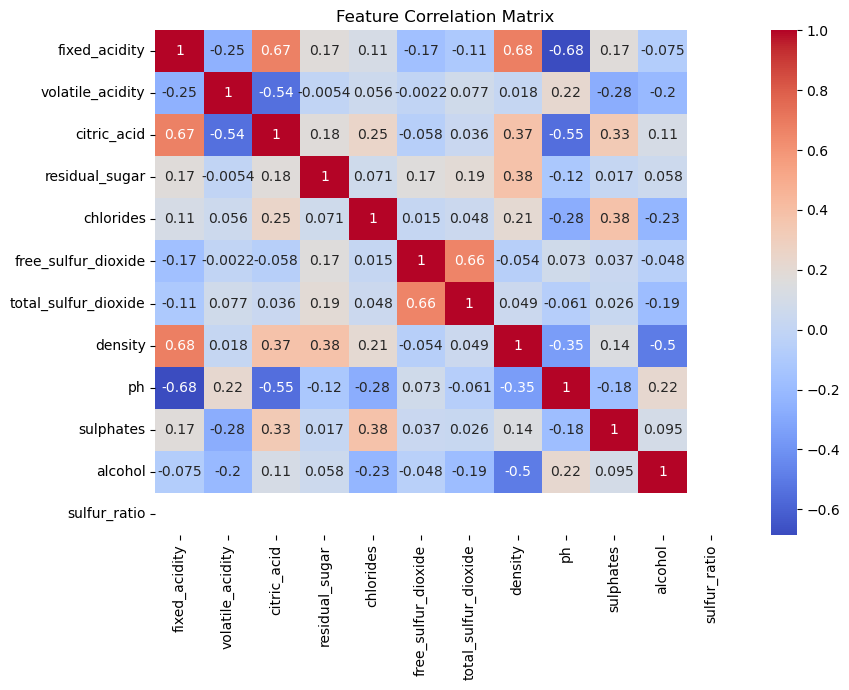

In [587]:
# 4. Data Visualization
def plot_distributions(df):
    # Correlation Matrix
    plt.figure(figsize=(9, 7))
    correlation = df.corr()
    # mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

plot_distributions(X_recovered.drop(columns=['id',"quality"], axis=1))

# Aykırı Değerlerin Tespiti ve Kaldırılması

Bu bölümde, veri setindeki aykırı değerleri tespit etmek ve kaldırmak için Local Outlier Factor (LOF) yöntemi kullanılmıştır. İşlemler adım adım aşağıda açıklanmıştır:

## 1. Veri Hazırlığı
- **Amaç:** `quality` ve `id` sütunlarını veri setinden çıkararak, sadece özelliklerin bulunduğu bir veri seti oluşturmak.
- **İşlem:**  
  - `X` değişkeni, `quality` ve `id` sütunları hariç tüm sütunları içerir.  
  - `y` değişkeni ise `quality` sütununu içerir.

## 2. LOF(Local Outlier Factor) Kullanarak Aykırı Değerlerin Tespiti
- **Amaç:** Aykırı değerleri tespit etmek.
- **İşlem:**  
  - Local Outlier Factor kullanılarak, her veri noktasının aykırı olup olmadığı belirlenir.  
  - `n_neighbors=5` parametresi, her veri noktasının 5 komşusuna göre değerlendirilmesini sağlar.
- **Detay:**  
  - `outlier_labels`, her veri noktası için `-1` (aykırı) veya `1` (normal) etiketlerini içerir.  
  - `non_outlier_mask`, aykırı olmayan veri noktalarını seçmek için kullanılır.

## 3. Aykırı Değerlerin Kaldırılması
- **Amaç:** Aykırı değerleri veri setinden çıkarmak.
- **İşlem:**  
  - `non_outlier_mask` kullanılarak, aykırı olmayan veri noktaları seçilir ve yeni bir veri seti oluşturulur (`X_cleaned` ve `y_cleaned`).

---

## Özet
Bu işlemler, veri setindeki aykırı değerleri tespit etmek ve kaldırmak için LOF yöntemini kullanır. Aykırı değerlerin kaldırılması, veri setinin daha temiz ve güvenilir olmasını sağlar. Bu da modelleme ve analiz süreçlerinde daha doğru sonuçlar elde edilmesine yardımcı olur.


In [588]:
# 5. Outlier Detection & Removal
# Using LOF for outlier detection
X = X_recovered.drop(columns=['quality', "id"])
y = X_recovered['quality']

lof = LocalOutlierFactor(n_neighbors=5)
outlier_labels = lof.fit_predict(X)
non_outlier_mask = outlier_labels != -1

# Remove outliers
X_cleaned = X[non_outlier_mask]
y_cleaned = y[non_outlier_mask]

print("Total samples:", len(X))
print("Non-outlier samples:", len(X_cleaned))
print("Outliers removed:", len(X) - len(X_cleaned))

Total samples: 1143
Non-outlier samples: 1087
Outliers removed: 56


In [589]:
# 6. Final Clean Dataset
clean_data = pd.concat([X_cleaned, y_cleaned], axis=1)
# clean_data.to_csv("path/to/WineQT_cleaned.csv", index=False)

In [590]:
continuous_vars_clean, categorical_vars_clean = separate_variables(clean_data)

Sürekli Değişkenler:
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol']

Kategorik Değişkenler:
['sulfur_ratio', 'quality']


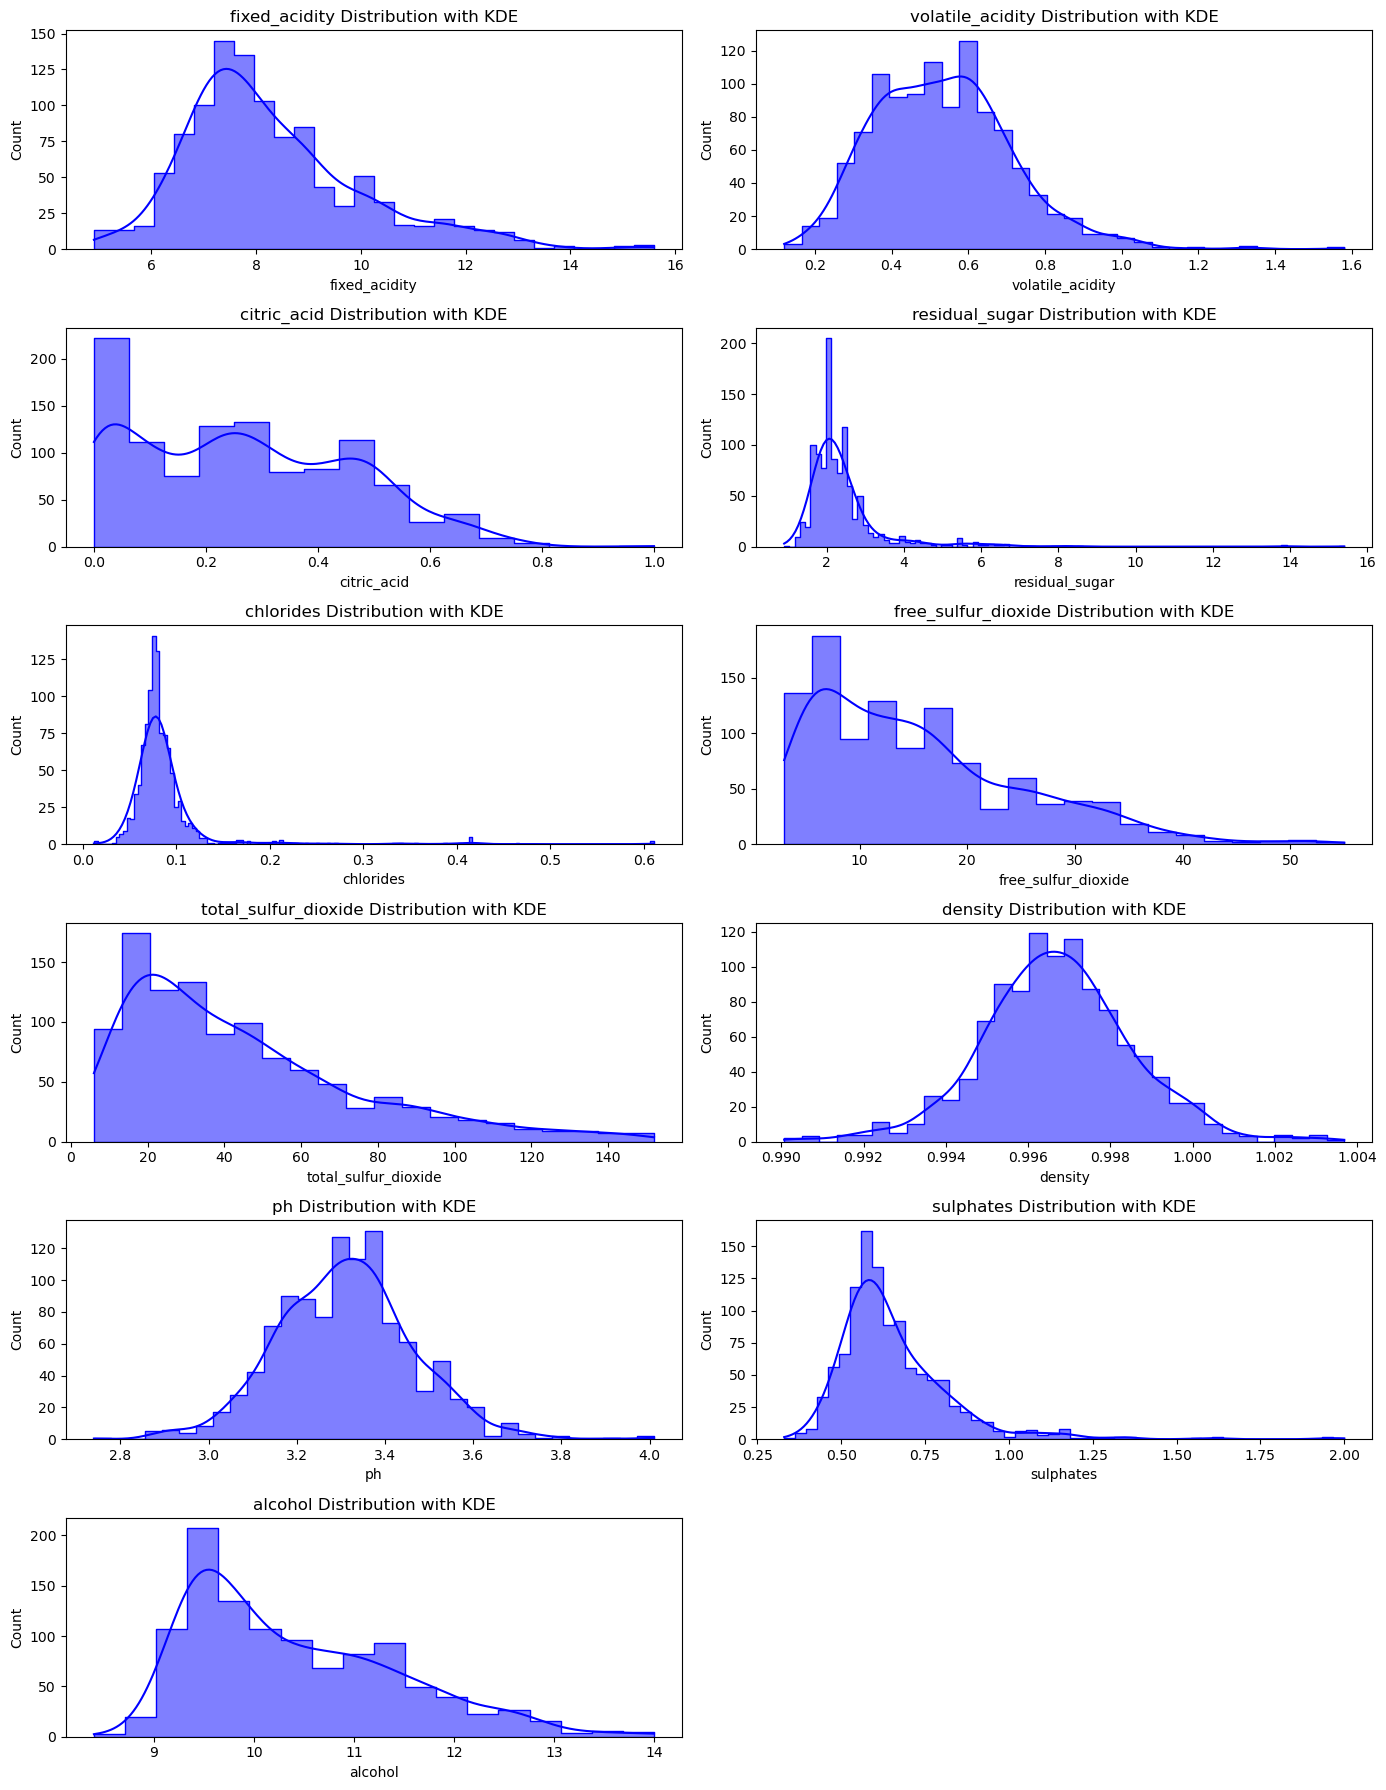

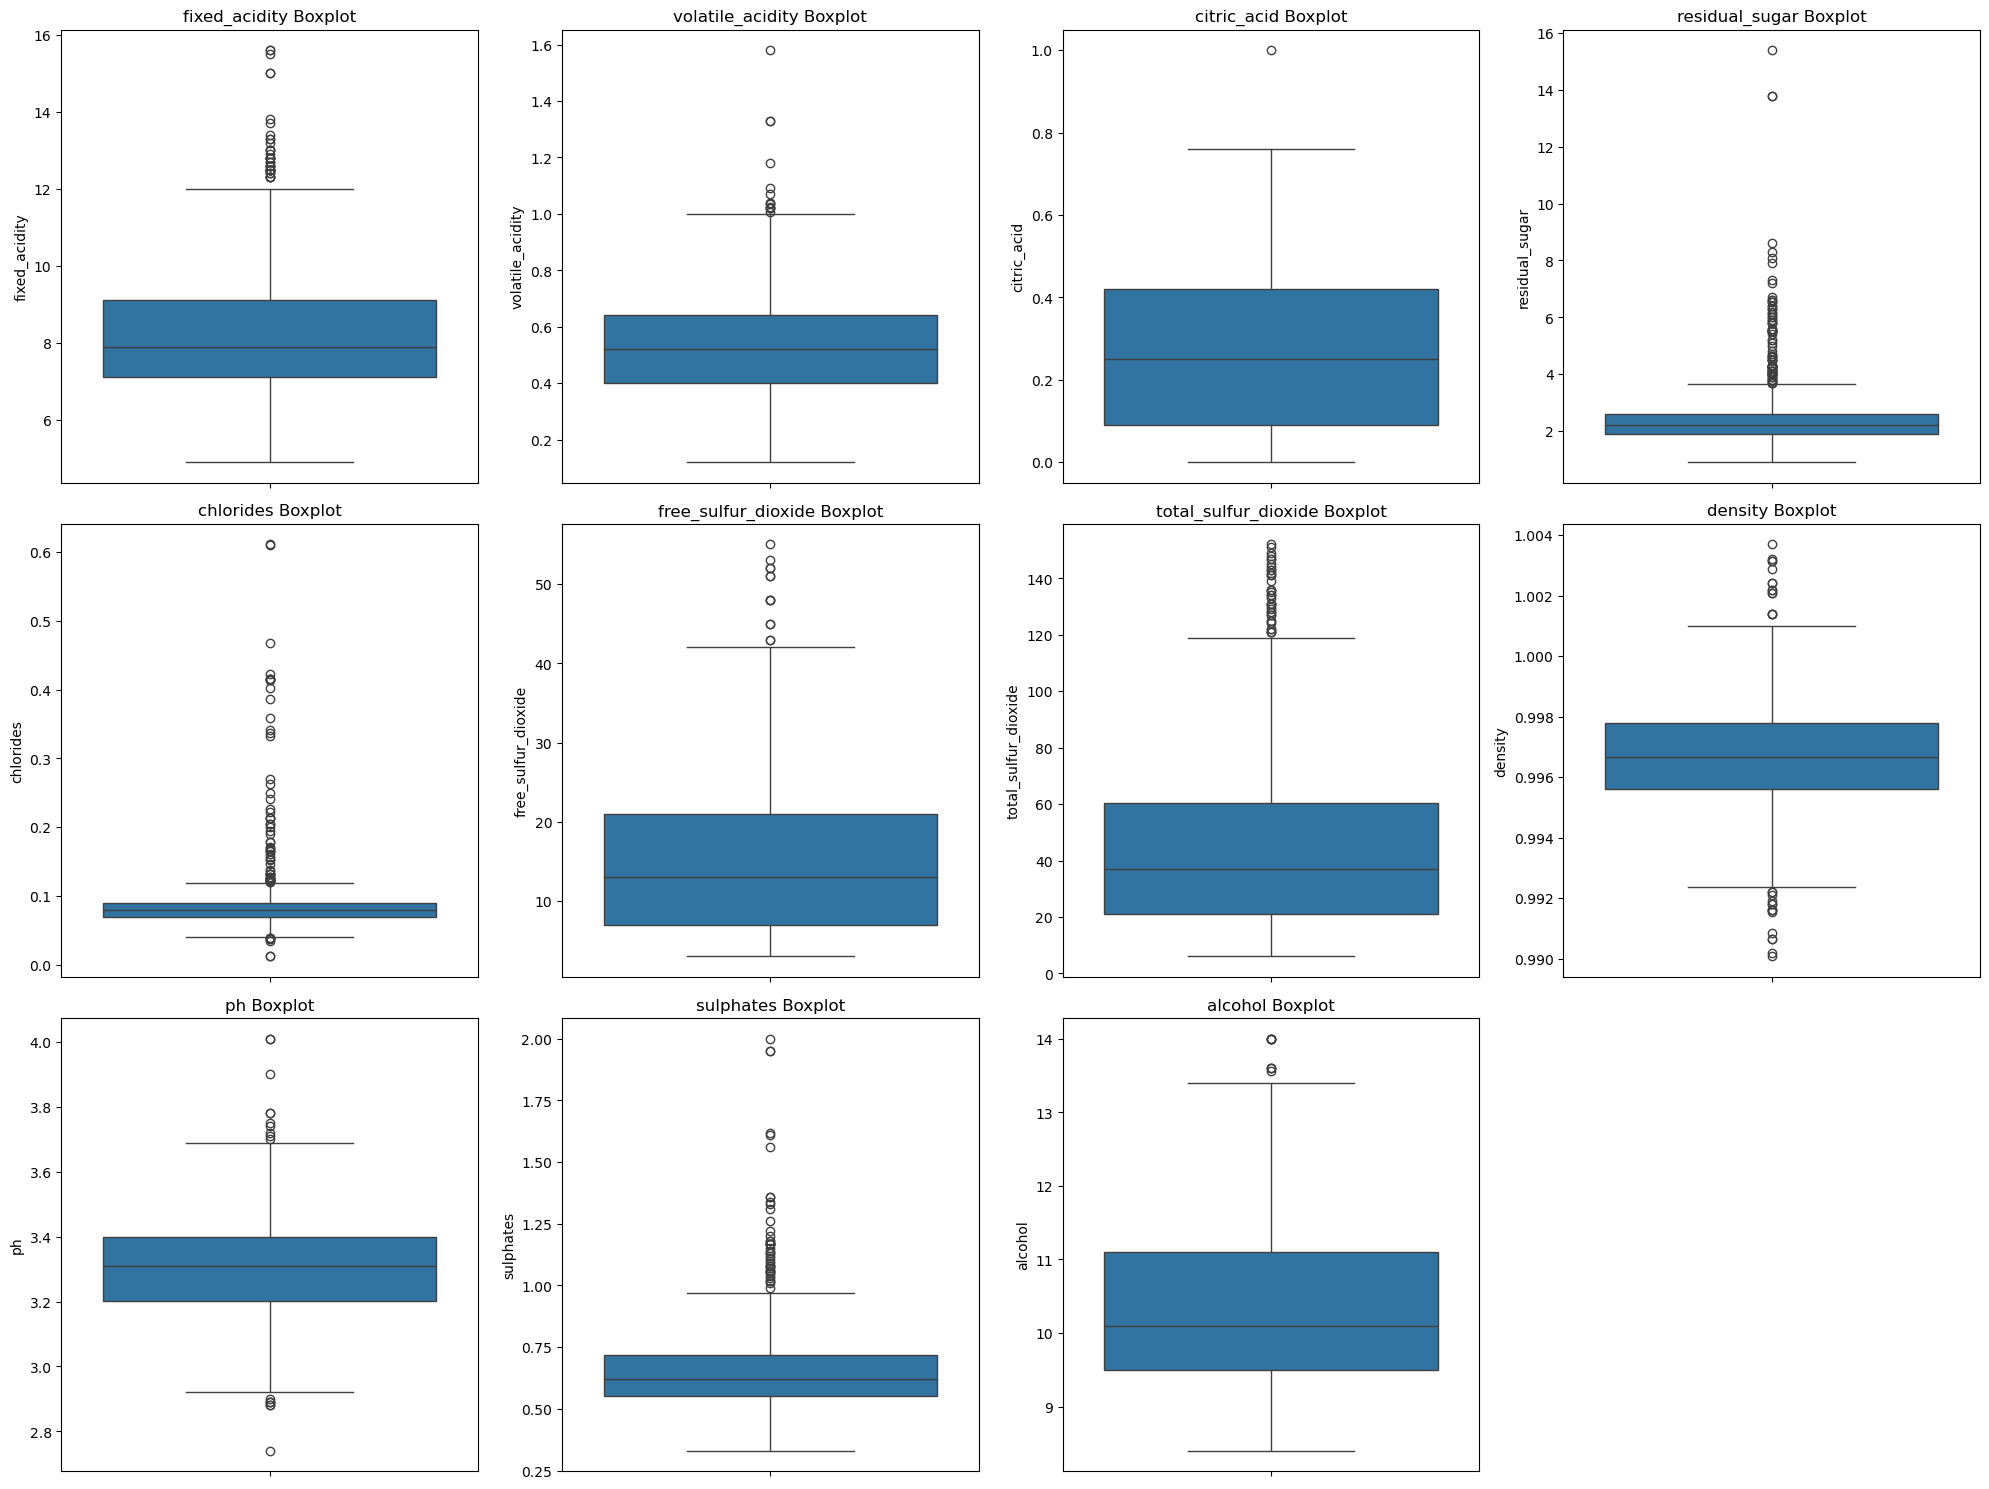

In [591]:
plot_kde_histograms(clean_data, continuous_vars_clean)
plot_boxplots(clean_data, continuous_vars_clean)

In [592]:
clean_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,sulfur_ratio,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1.0,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1.0,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1.0,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.0,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1.0,2


## MODELLER

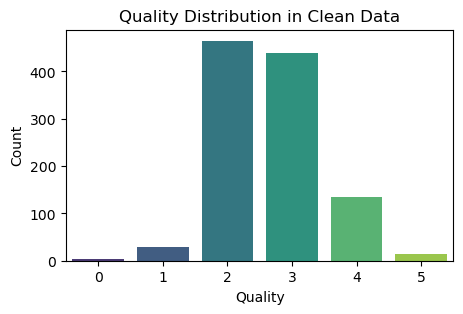

In [593]:
# Quality dağılımını göster
plt.figure(figsize=(5, 3))
sns.countplot(data=clean_data, x='quality', palette='viridis')
plt.title('Quality Distribution in Clean Data')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

In [594]:
# # Veriyi standardize et
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # DataFrame'e geri dönüştür
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Training SVC...

SVC Results:
Accuracy: 0.6376

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.75      0.77      0.76       103
           3       0.55      0.67      0.60        81
           4       0.43      0.25      0.32        24
           5       0.00      0.00      0.00         3

    accuracy                           0.64       218
   macro avg       0.29      0.28      0.28       218
weighted avg       0.60      0.64      0.62       218


Training SVC2...

SVC2 Results:
Accuracy: 0.6376

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.73      0.77      0.75       103
           3       0.55      0.65      0.60        81
           4       0.50      0.29      0

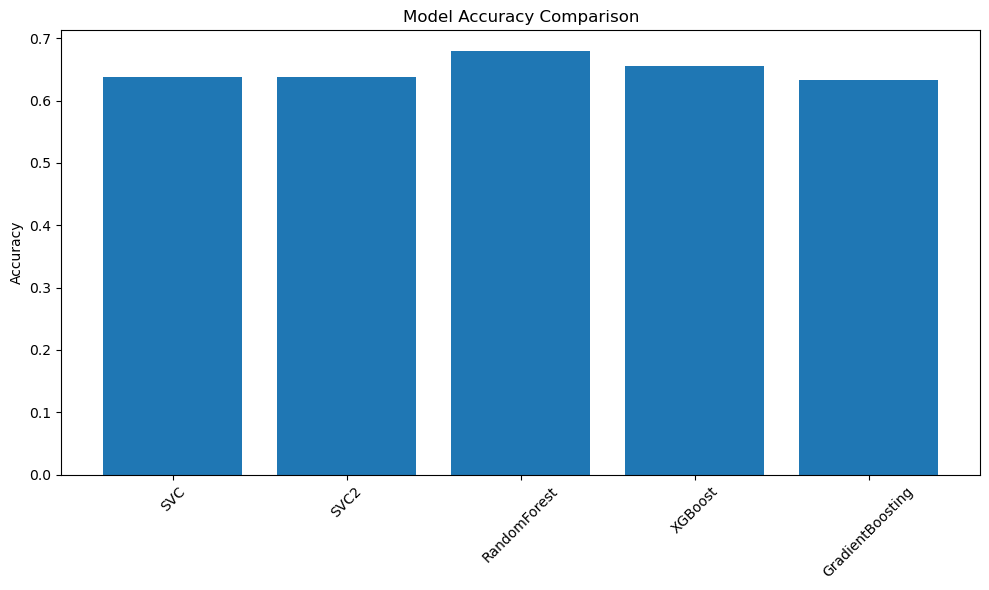


Cross-validating SVC...
SVC CV Accuracy: 0.6008 (+/- 0.0497)

Cross-validating SVC2...
SVC2 CV Accuracy: 0.5852 (+/- 0.0382)

Cross-validating RandomForest...
RandomForest CV Accuracy: 0.5842 (+/- 0.0263)

Cross-validating XGBoost...
XGBoost CV Accuracy: 0.5575 (+/- 0.0275)

Cross-validating GradientBoosting...
GradientBoosting CV Accuracy: 0.5621 (+/- 0.0188)

Best Model: SVC with CV accuracy: 0.6008


In [595]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Veriyi hazırla

scaler = StandardScaler()
clean_data_scaled = pd.DataFrame(scaler.fit_transform(clean_data.drop(columns=['quality'])), columns=clean_data.drop(columns=['quality']).columns)
clean_data_scaled['quality'] = clean_data['quality'].values


X = clean_data_scaled.drop(['quality'], axis=1)
y = clean_data_scaled['quality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelleri oluştur
models = {
    'SVC': SVC(kernel='rbf', random_state=42),
    'SVC2': SVC(kernel='poly', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Sonuçları saklamak için dictionary
results = {}

# Her model için eğitim ve değerlendirme
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Sonuçları sakla
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'predictions': y_pred
    }
    
    # Sonuçları yazdır
    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # # Confusion Matrix
    # plt.figure(figsize=(8,6))
    # cm = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title(f'{name} Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()

# Model karşılaştırma grafiği
plt.figure(figsize=(10,6))
accuracies = [results[model]['accuracy'] for model in results]
plt.bar(results.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cross-validation results dictionary
cv_results = {}

# Perform cross-validation for each model
for name, model in models.items():
    print(f"\nCross-validating {name}...")
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Kfold ile en iy modeli bul
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\nBest Model: {best_model_name} with CV accuracy: {best_model_score:.4f}")

Class distribution before SMOTE:
Counter({2: 465, 3: 440, 4: 134, 1: 30, 5: 14, 0: 4})

Minimum samples in any class: 4

Using k_neighbors = 3


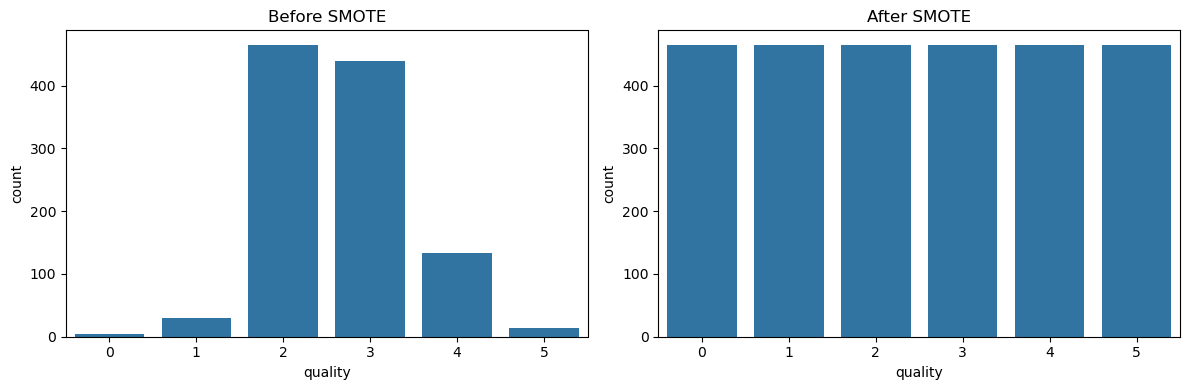


Shape comparison:
Original shape: (1087, 13)
Balanced shape: (2790, 13)

Final class distribution:
Counter({2: 465, 3: 465, 4: 465, 1: 465, 5: 465, 0: 465})


In [596]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Önce sınıf dağılımını kontrol et
print("Class distribution before SMOTE:")
print(Counter(clean_data['quality']))

# Her sınıftaki minimum örnek sayısını bul
min_samples = min(Counter(clean_data['quality']).values())
print(f"\nMinimum samples in any class: {min_samples}")

# SMOTE parametrelerini ayarla (k_neighbors minimum örnek sayısından küçük olmalı)
k_neighbors = min(min_samples - 1, 5)  # En az 1 komşu, en fazla 5
print(f"\nUsing k_neighbors = {k_neighbors}")

# Veriyi hazırla
# X = clean_data.drop(['quality', 'Id'], axis=1)
X = clean_data.drop(['quality'], axis=1)
y = clean_data['quality']

# Düzeltilmiş SMOTE
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Sonuçları görselleştir
plt.figure(figsize=(12,4))

# SMOTE öncesi
plt.subplot(1,2,1)
sns.countplot(data=clean_data, x='quality')
plt.title('Before SMOTE')

# SMOTE sonrası
plt.subplot(1,2,2)
sns.countplot(x=y_resampled)
plt.title('After SMOTE')

plt.tight_layout()
plt.show()

# Dengelenmiş veriyi DataFrame'e çevir
balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
balanced_data['quality'] = y_resampled

print("\nShape comparison:")
print(f"Original shape: {clean_data.shape}")
print(f"Balanced shape: {balanced_data.shape}")
print("\nFinal class distribution:")
print(Counter(y_resampled))


Training SVC...

SVC Results:
Accuracy: 0.7778

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        91
           1       0.77      0.93      0.84        95
           2       0.67      0.55      0.61        92
           3       0.56      0.43      0.49        90
           4       0.75      0.72      0.74        89
           5       0.88      1.00      0.94       101

    accuracy                           0.78       558
   macro avg       0.76      0.77      0.76       558
weighted avg       0.76      0.78      0.77       558


Training SVC2...

SVC2 Results:
Accuracy: 0.7240

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        91
           1       0.76      0.75      0.76        95
           2       0.59      0.51      0.55        92
           3       0.49      0.54      0.52        90
           4       0.69      0.65      0

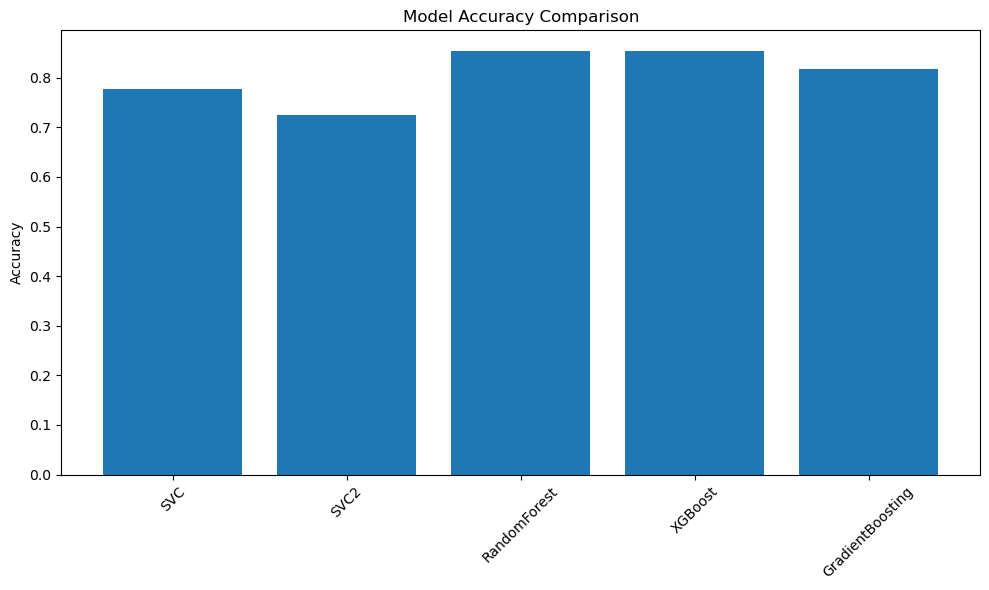


Cross-validating SVC...
SVC CV Accuracy: 0.7681 (+/- 0.0099)

Cross-validating SVC2...
SVC2 CV Accuracy: 0.7262 (+/- 0.0151)

Cross-validating RandomForest...
RandomForest CV Accuracy: 0.8283 (+/- 0.0105)

Cross-validating XGBoost...
XGBoost CV Accuracy: 0.8233 (+/- 0.0155)

Cross-validating GradientBoosting...
GradientBoosting CV Accuracy: 0.8029 (+/- 0.0083)

Best Model: RandomForest with CV accuracy: 0.8283


In [597]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


# Veriyi hazırla

scaler = StandardScaler()
balanced_data_scaled = pd.DataFrame(scaler.fit_transform(balanced_data.drop(columns=['quality'])), columns=balanced_data.drop(columns=['quality']).columns)
balanced_data_scaled['quality'] = balanced_data['quality'].values

X = balanced_data_scaled.drop(['quality'], axis=1)
y = balanced_data_scaled['quality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelleri oluştur
models = {
    'SVC': SVC(kernel='rbf', random_state=42),
    'SVC2': SVC(kernel='poly', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Sonuçları saklamak için dictionary
results = {}

# Her model için eğitim ve değerlendirme
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Sonuçları sakla
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'predictions': y_pred
    }
    
    # Sonuçları yazdır
    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # # Confusion Matrix
    # plt.figure(figsize=(8,6))
    # cm = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title(f'{name} Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()

# Model karşılaştırma grafiği
plt.figure(figsize=(10,6))
accuracies = [results[model]['accuracy'] for model in results]
plt.bar(results.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Kfold ile en iy modeli bul
# best_model_name = max(cv_results, key=cv_results.get)
# best_model_score = cv_results[best_model_name]
# print(f"\nBest Model: {best_model_name} with CV accuracy: {best_model_score:.4f}")

cv_results = {}

# Perform cross-validation for each model
for name, model in models.items():
    print(f"\nCross-validating {name}...")
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Kfold ile en iy modeli bul
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\nBest Model: {best_model_name} with CV accuracy: {best_model_score:.4f}")

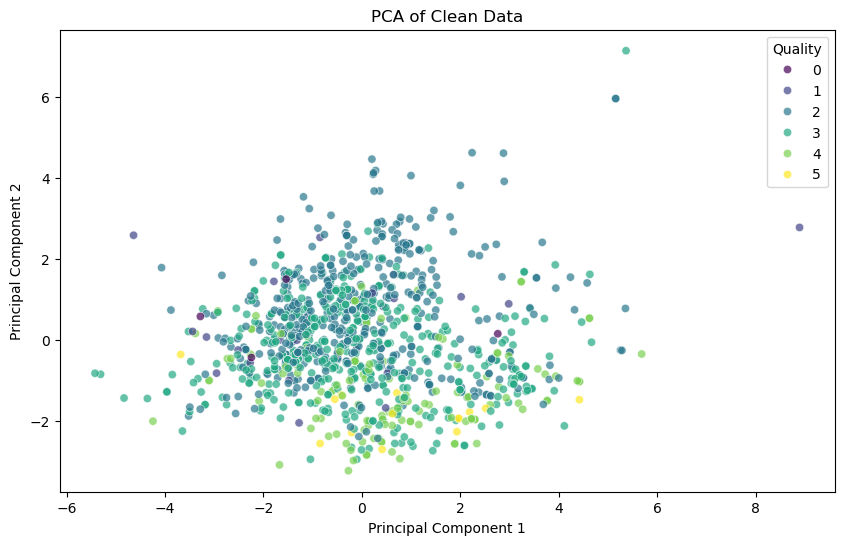

In [598]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# 'quality' sütununu ayır
X = clean_data.drop(columns=['quality'])
y = clean_data['quality']

# Veriyi standardize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA uygulama
pca = PCA(n_components=2)  # 2 bileşene indirgeme
X_pca = pca.fit_transform(X_scaled)

# PCA sonuçlarını DataFrame'e dönüştür
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['quality'] = y.values

# PCA sonuçlarını görselleştir
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue='quality', palette='viridis', alpha=0.7)
plt.title('PCA of Clean Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Quality')
plt.show()


Training SVC...

SVC Results:
Accuracy: 0.5138

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.65      0.60      0.62       103
           3       0.42      0.59      0.49        81
           4       0.25      0.08      0.12        24
           5       0.00      0.00      0.00         3

    accuracy                           0.51       218
   macro avg       0.22      0.21      0.21       218
weighted avg       0.49      0.51      0.49       218


Training SVC2...

SVC2 Results:
Accuracy: 0.4679

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.67      0.40      0.50       103
           3       0.40      0.75      0.52        81
           4       0.00      0.00      0

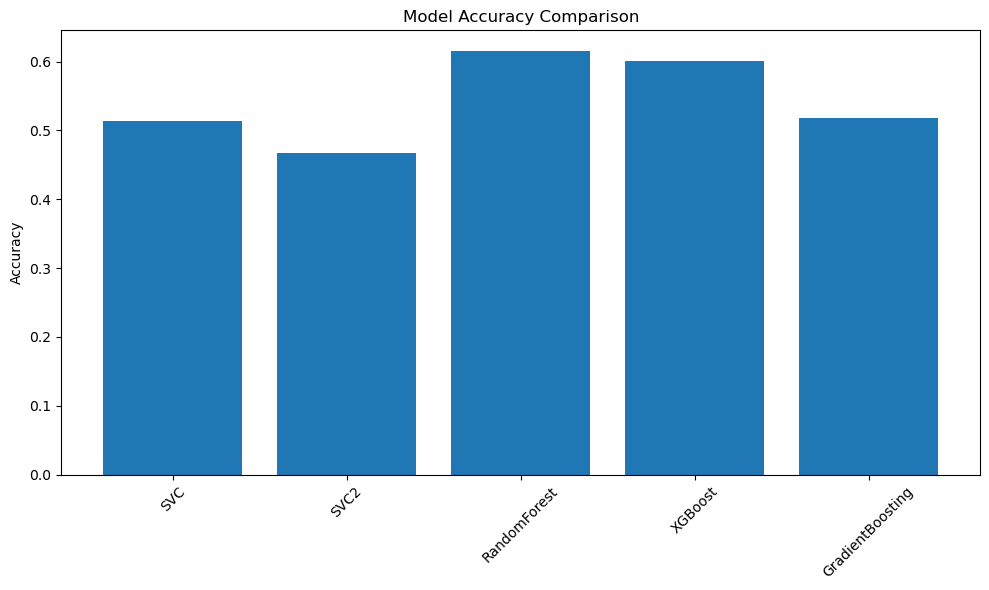


Cross-validating SVC...
SVC CV Accuracy: 0.5161 (+/- 0.0224)

Cross-validating SVC2...
SVC2 CV Accuracy: 0.4986 (+/- 0.0172)

Cross-validating RandomForest...
RandomForest CV Accuracy: 0.4674 (+/- 0.0212)

Cross-validating XGBoost...
XGBoost CV Accuracy: 0.4628 (+/- 0.0273)

Cross-validating GradientBoosting...
GradientBoosting CV Accuracy: 0.4462 (+/- 0.0325)

Best Model: SVC with CV accuracy: 0.5161


In [599]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


# Veriyi hazırla

scaler = StandardScaler()
pca_df_scaled = pd.DataFrame(scaler.fit_transform(pca_df.drop(columns=['quality'])), columns=pca_df.drop(columns=['quality']).columns)
pca_df_scaled['quality'] = pca_df['quality'].values

X = pca_df_scaled.drop(['quality'], axis=1)
y = pca_df_scaled['quality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelleri oluştur
models = {
    'SVC': SVC(kernel='rbf', random_state=42),
    'SVC2': SVC(kernel='poly', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Sonuçları saklamak için dictionary
results = {}

# Her model için eğitim ve değerlendirme
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Sonuçları sakla
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'predictions': y_pred
    }
    
    # Sonuçları yazdır
    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    

# Model karşılaştırma grafiği
plt.figure(figsize=(10,6))
accuracies = [results[model]['accuracy'] for model in results]
plt.bar(results.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# En iyi modeli bul
# Cross-validation ile en iyi modeli bul
# best_model_name = None
# best_model_score = 0

# for name, model in models.items():
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
#     mean_score = scores.mean()
#     print(f"{name} Cross-Validation Accuracy: {mean_score:.4f}")
    
#     if mean_score > best_model_score:
#         best_model_score = mean_score
#         best_model_name = name

# print(f"\nBest Model: {best_model_name} with cross-validation accuracy: {best_model_score:.4f}")

cv_results = {}

# Perform cross-validation for each model
for name, model in models.items():
    print(f"\nCross-validating {name}...")
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Kfold ile en iy modeli bul
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\nBest Model: {best_model_name} with CV accuracy: {best_model_score:.4f}")